# Convolutional Neural Networks

## Project: Algorithm for a Dog Breed Identification App 

---


### What's Here 

In this notebook, I have developed an algorithm that could be used as part of a mobile or web app. The code accepts any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling!  

The algorithm developed here has scope for improvement, but this solution nonetheless creates a fun user experience!

### The Road Ahead

This notebook has been broken into separate steps. Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

The required human and dog datasets have been downloaded as follows:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  


In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) has been used to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  One of these detectors can be downloaded and stored it in the `haarcascades` directory.  The next code cell demonstrates how to use this detector to find human faces in a sample image.

Number of faces detected: 2


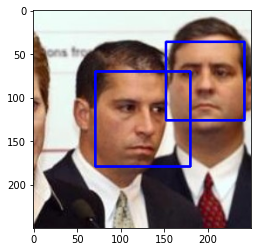

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Writing a Human Face Detector

This procedure has been used here to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assessing the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  But we see that our algorithm falls short of this goal, but still gives acceptable performance.  I have extracted the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

#### Performance of the `face_detector` function:
- 98% of the first 100 images in `human_files` have a detected human face.
- 6% of the first 100 images in `dog_files` have a detected human face.

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humans_detected = 0
for file in human_files_short:
    if(face_detector(file)):
        humans_detected+=1
print("Percentage of the first 100 images in human_files that have a detected human face is: ", humans_detected*100.0/len(human_files_short),"%")

humans_detected = 0
for file in dog_files_short:
    if(face_detector(file)):
        humans_detected+=1
print("Percentage of the first 100 images in dog_files that have a detected human face is: ", humans_detected*100.0/len(dog_files_short),"%")

Percentage of the first 100 images in human_files that have a detected human face is:  98.0 %
Percentage of the first 100 images in dog_files that have a detected human face is:  6.0 %


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) has been used to detect dogs in images.  

### Obtaining Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, I have written a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output will be an integer between 0 and 999, inclusive.

In [10]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # resize images to 224 x 224
    transform = transforms.Compose(transforms = [transforms.RandomResizedCrop(224),
                                                 transforms.ToTensor()])
    im = transform(Image.open(img_path))
    
    # unsqueezing transformed image matrix 
    im = im.view(1,3,224,224)
    im.numpy()
    
    # loading data on GPU
    if torch.cuda.is_available():
            im = im.cuda()
            
    # applying model
    output = VGG16(im)
    
    # getting class index
    _, idx = torch.max(output, 1)
    
    return idx # predicted class index

### (IMPLEMENTATION) Writing a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), one can see that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Using this ideas, the `dog_detector` function below has been implemented, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    val = False
    if 151<=VGG16_predict(img_path)<=268 :
        val = True
    return val # true/false

In [12]:
# Testing the dog_detector function
img = "dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"
VGG16_predict(img)

tensor([252], device='cuda:0')

__Performance of the `dog_detector` function:__ 
- Percentage of the first 100 images in human_files that have a detected dog is:  2.0 %
- Percentage of the first 100 images in dog_files that have a detected dog is:  88.0 %

In [13]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


dogs_detected = 0
for file in human_files_short:
    if(dog_detector(file)):
        dogs_detected+=1
print("Percentage of the first 100 images in human_files that have a detected dog is: ", dogs_detected*100.0/len(human_files_short),"%")

dogs_detected = 0
for file in dog_files_short:
    if(dog_detector(file)):
        dogs_detected+=1
print("Percentage of the first 100 images in dog_files that have a detected dog is: ", dogs_detected*100.0/len(dog_files_short),"%")

Percentage of the first 100 images in human_files that have a detected dog is:  2.0 %
Percentage of the first 100 images in dog_files that have a detected dog is:  88.0 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I have created a CNN that classifies dog breeds. The following CNN has been created _from scratch_ (so, without transfer learning _yet_).  In Step 4 of this notebook, I have gone further in utilizing existing pre-trained models to use transfer learning to create a CNN that attains greatly improved accuracy.

It is worth mentioning that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://www.101dogbreeds.com/wp-content/uploads/2017/07/French-Brittany.jpg" width="100"> | <img src="https://cdn.fotofits.com/petzlover/gallery/img/l/welsh-springer-spaniel-dog-801989.jpeg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  


Likewise, recall that labradors come in yellow, chocolate, and black.  My vision-based algorithm presented here conquers this high intra-class variation to determine how to classify all of these different shades as the same breed.  


Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://www.101dogbreeds.com/wp-content/uploads/2018/10/Labrador-Retriever.jpg" width="150"> | <img src="https://www.101dogbreeds.com/wp-content/uploads/2018/10/Miniature-Labrador-Retriever.jpg" width="240"> | <img src="https://www.101dogbreeds.com/wp-content/uploads/2015/07/Black-Lab-Pointer.jpg" width="220">

It is also worth mentioning that random chance presents an __exceptionally low bar__: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  



### (IMPLEMENTATION) Specifying Data Loaders for the Dog Dataset

The code cell below to uses three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).

In [14]:
## Specify data loaders
import os
from torchvision import datasets
from torchvision import transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Using GPU...")
else:print("Training on CPU.")

### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# Augmenting the data
train_transform = transforms.Compose(transforms = [transforms.RandomResizedCrop(224),
                                                  transforms.RandomRotation(30),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor()])

test_transform = transforms.Compose(transforms = [transforms.Resize(225),
                                                  transforms.CenterCrop(224),
                                                  transforms.ToTensor()])

num_workers=0

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# specifying batch size
batch_size = 32

# defining data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True , num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

loaders_scratch = {'train':train_loader, 'valid':valid_loader, 'test':test_loader}

print(f"Tain_data length: {len(train_data)}, Valid_data length: {len(valid_data)}, Test_data length: {len(test_data)}")

Using GPU...
Tain_data length: 6680, Valid_data length: 835, Test_data length: 836


**My chosen procedure for preprocessing the data**:

- I have used random resized crop for train data images, making them 224 x 224. For test data images, I have first resized the images to 225 x 225, then center cropped them to 224 x 224.
- For augmentation, I have used horizontal flip and rotation by 30 degrees on the train data.

### (IMPLEMENTATION) Model Architecture


In [15]:
# getting number of classes
num_labels = 0
for item in glob("dogImages/train/*"):
    num_labels+=1
print(num_labels)

133


In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # conv1: input channels with image matrix size - (3x224x224)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # batch normalization
        self.bnorm = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # conv2: input channels and matrix size - (16x112x112)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        # conv3: input channels and matrix size - (32x56x56)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # pool: reduces input matrix dimensions by half
        self.pool = nn.MaxPool2d(2, 2)
        # fc1: fully-connected layer with input size (128x28x28)
        self.fc1 = nn.Linear(128*28*28, 1024)
        # fc2: fully-connected layer with hidden input units = 1024
        self.fc2 = nn.Linear(1024, 133)
        self.dropout = nn.Dropout(0.25)
            
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(self.bnorm((F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening into a 1-D vector
        x = x.view(-1, 128*28*28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [19]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


__Outline of the steps I took to get to my final CNN architecture and my reasoning at each step.__ 
- I have used various pairs of 2-D convolution matrices for obtaining feature maps with pooling layers, of appropriate padding size as per formula: (W-F+2P)/(s+1) to get dimensions of resultant convolved image. In the end, followed by a network of dense layers.
  1. (conv1) : 2-D convolution layer with kernel size 3 x 3 with input image size 224 x 224
  2. (bnorm) : normalizing the channels to keep weights closer to zero
  3. (pool) : 2-D maxpool layer of size 2x2 for reducing dimensions by half
  4. (conv2) : 2-D convolution layer with kernel size 3 x 3 input image size 112 x 112
  5. (pool) : 2-D maxpool layer for reducing dimensions 
  6. (conv3) : 2-D convolution layer with kernel size 3 x 3 input image size 56 x 56
  7. (pool) : 2-D maxpool layer for reducing dimensions
  8. Flattening the 28 x 28 matric into a linear vector for applying dense layers
  9., 10. (fc1), (fc2) : fully connected layers for the dense network 

- I have used ReLU activation function in between the layers and a dropout with p = 0.25 before each dense layer.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

I have used the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  The chosen loss function has been chosen as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [28]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

I have trained and validated my model in the code cell below. The final parameters have been [saved](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            #clear gradients
            optimizer.zero_grad()
            #forward pass
            output = model(data)
            # compute training loss using defined criterion
            loss = criterion(output, target)
            # backpropagating losses
            loss.backward()
            # optimizer step 
            optimizer.step()
            # update train loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # get validation loss
            loss = criterion(output, target)
            # update val loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving model... Validation loss decreased ({:.6f} --> {:.6f}).  '.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            

        
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 
                      'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.879953 	Validation Loss: 4.845758
Saving model... Validation loss decreased (inf --> 4.845758).  
Epoch: 2 	Training Loss: 4.786806 	Validation Loss: 4.687518
Saving model... Validation loss decreased (4.845758 --> 4.687518).  
Epoch: 3 	Training Loss: 4.646651 	Validation Loss: 4.586614
Saving model... Validation loss decreased (4.687518 --> 4.586614).  
Epoch: 4 	Training Loss: 4.576566 	Validation Loss: 4.540505
Saving model... Validation loss decreased (4.586614 --> 4.540505).  
Epoch: 5 	Training Loss: 4.535815 	Validation Loss: 4.412902
Saving model... Validation loss decreased (4.540505 --> 4.412902).  
Epoch: 6 	Training Loss: 4.481984 	Validation Loss: 4.473015
Epoch: 7 	Training Loss: 4.440012 	Validation Loss: 4.302296
Saving model... Validation loss decreased (4.412902 --> 4.302296).  
Epoch: 8 	Training Loss: 4.401198 	Validation Loss: 4.337531
Epoch: 9 	Training Loss: 4.360374 	Validation Loss: 4.313285
Epoch: 10 	Training Loss: 4.330809 	Valida

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

I have then tried out my model on the test dataset of dog images. The code cell below has been used to calculate and print the test loss and accuracy. The accuracy achieved is 13% (don't forget I built the CNN from scratch! :p).

In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.749231


Test Accuracy: 13% (115/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I have now used transfer learning to create a CNN that can identify dog breed from images.

### (IMPLEMENTATION) Specifying Data Loaders for the Dog Dataset

I have used the same data loaders from the previous step, when I created a CNN from scratch.

In [32]:
loaders_transfer = {'train':train_loader, 'valid':valid_loader, 'test':test_loader}

### (IMPLEMENTATION) Model Architecture

I have used transfer learning to create a CNN to classify dog breed in the code cell below, and saved my initialized model as the variable `model_transfer`.

In [36]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.resnet50(pretrained=True)
# freeze weights of pre-trained convolutinal layers
for param in model_transfer.parameters():
    param.require_grad = False
    
# modifying the fc layers for fine tuning
model_transfer.fc = nn.Sequential(nn.Linear(2048, 1090),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.25),
                                  nn.Linear(1090, 133))

# unfreezing weights in new layers for training
for param in model_transfer.fc.parameters():
    param.require_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()
    print("CUDA is available")

CUDA is available


__Outline of the steps I took to get to my final CNN architecture and my reasoning at each step.__ 

- I have used the ResNet50 model architecture for transfer learning as it is trained on ImageNet dataset that also contains classes for various dog breeds, similar to my current data.
- As the data is similar to original one on which ResNet50 is pre-trained, even the higher level features needed in my model would be very similar, hence I have kept the convolutional architecture as it is with the weights frozen.
- I have modified the fully-connected layer at the end of ResNet50 to adjust the number of classes from 1000 to 133. This portion of the model with be freshly trained.
- I have introduced a hidden layer in the fully-connected architecture with no. of output nodes = 1090 i.e. midway between input of dense layers (2048) and required no. of target variables (133).
- I have used ReLU activation function and a dropout layer betwee the two fully-connected layers at end.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [37]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

I have trained and validated my model in the code cell below. The final model parameters have been saved at filepath `'model_transfer.pt'`.

In [38]:
# train the model
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.700561 	Validation Loss: 4.139253
Saving model... Validation loss decreased (inf --> 4.139253).  
Epoch: 2 	Training Loss: 3.790681 	Validation Loss: 2.561065
Saving model... Validation loss decreased (4.139253 --> 2.561065).  
Epoch: 3 	Training Loss: 2.628277 	Validation Loss: 1.532700
Saving model... Validation loss decreased (2.561065 --> 1.532700).  
Epoch: 4 	Training Loss: 1.902247 	Validation Loss: 1.086498
Saving model... Validation loss decreased (1.532700 --> 1.086498).  
Epoch: 5 	Training Loss: 1.562070 	Validation Loss: 0.789174
Saving model... Validation loss decreased (1.086498 --> 0.789174).  
Epoch: 6 	Training Loss: 1.320823 	Validation Loss: 0.748056
Saving model... Validation loss decreased (0.789174 --> 0.748056).  
Epoch: 7 	Training Loss: 1.197315 	Validation Loss: 0.595996
Saving model... Validation loss decreased (0.748056 --> 0.595996).  
Epoch: 8 	Training Loss: 1.101122 	Validation Loss: 0.569753
Saving model... Validation loss de

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

I have then tried out my model on the test dataset of dog images. The code cell below calculates and prints the test loss and accuracy. 

In [39]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.358711


Test Accuracy: 86% (726/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

I have written a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by my model (one using transfer learning).  

In [40]:
### This function takes a path to an image as input
### and returns the dog breed that is predicted by the model.

data_transfer = {'train':train_data,
                 'valid': valid_data,
                 'test': test_data}

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # preprocessing the image
    transform = transforms.Compose(transforms = [transforms.Resize(225),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor()])
    im = transform(Image.open(img_path))
    im = im.view(1,3,224,224)
    im.numpy()
    if torch.cuda.is_available():
            im = im.cuda()
    # passing through the trained model
    output = model_transfer(im)
    _, idx = torch.max(output, 1)
    return class_names[idx]

---
<a id='step5'></a>
## Step 5: Write the Algorithm

I have written an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, the predicted breed is returned.
- if a __human__ is detected in the image, the resembling dog breed is returned.
- if __neither__ is detected in the image, an output is provided that indicates an error.

The `face_detector` and `human_detector` functions developed above have been used for detecting humans and dogs in images. I have used the __CNN from Step 4__ to predict dog breed.  



### (IMPLEMENTATION) Writing my Algorithm

In [41]:
### Write the algorithm.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    
    if dog_detector(img_path):
        print("Hello dog!")
        breed = predict_breed_transfer(img_path)
    elif face_detector(img_path):
        print("Hello human!")
        breed = predict_breed_transfer(img_path)
    else:
        breed = "ERROR! You neither look like a human nor a dog!"
    
    return ("You look like a... "+ breed)

---
<a id='step6'></a>
## Step 6: Test the Algorithm

In this section, I have taken my new algorithm for a spin!  What kind of dog does the algorithm think that _a person_ looks like?  If you have a dog, does it predict your dog's breed accurately?  If it is given a random image, does it mistakenly think that itt is a dog?

### (IMPLEMENTATION) Testing my Algorithm on Sample Images!

I have tested my algorithm on a few images on my computer.  Feel free to use any images you like!

__So, is the output better than I expected :) ?  Or worse :( ?__

The outputs are better than my expectations considering the accuracy achieved by my dog-breed classifier was 86%. 

__Few possible points for further improvement:__

This project can be improved further as follows:
- Increasing the number of epochs in the training
- Reducing the learning rate 
- Retraining the whole CNN architecture on new data instead of freezing the convolution layers
- Experimenting with parameters like size of batches, no. of layers, optimizer and loss function.

Hello human!
You look like a... Papillon


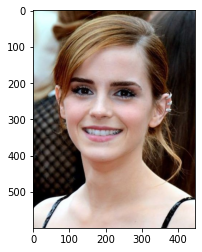

In [43]:
## Execute my algorithm from Step 6 on
## a few images on my computer.
print(run_app("447px-Emma_Watson_2013.jpg"))

Hello human!
You look like a... American water spaniel


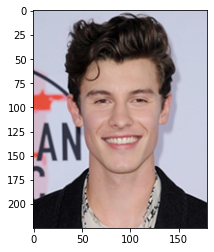

In [44]:
print(run_app("/content/shawn-mendes.jpg"))


Hello dog!
You look like a... Labrador retriever


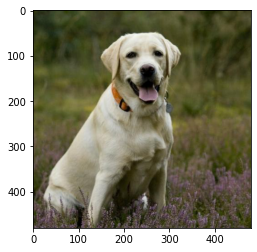

In [45]:
print(run_app('/content/labrador-retriever.jpg'))

Hello dog!
You look like a... English cocker spaniel


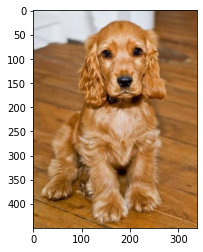

In [46]:
print(run_app('/content/cocker-spaniel.jpg'))

Hello dog!
You look like a... Italian greyhound


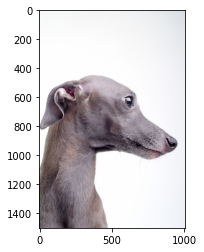

In [49]:
print(run_app("/content/Italian-Greyhound.jpg"))

You look like a... ERROR! You neither look like a human nor a dog!


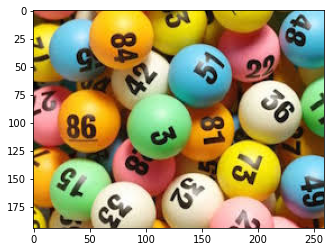

In [50]:
print(run_app('/content/random.jpeg'))

You look like a... ERROR! You neither look like a human nor a dog!


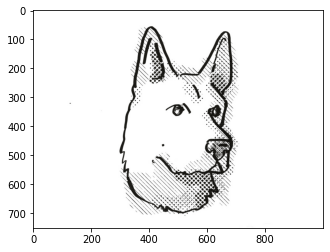

In [51]:
print(run_app("/content/german-shepherd-art.jpg"))

You look like a... ERROR! You neither look like a human nor a dog!


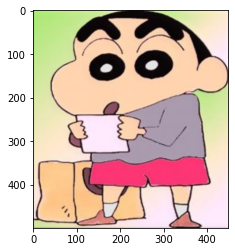

In [52]:
print(run_app("/content/crayon-shinchan.jpg"))